In [31]:
%matplotlib inline
import everest
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from astropy.constants import R_sun, R_earth
import astropy.units as u
from robin import TransitModel, TransitParams

In [32]:
zeit = Table.read('data/zeit.csv')

In [33]:
zeit[6]

EPIC,per,rp,t0,inc,ecc,w,a,mstar,mstar_err,rstar,rstar_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
211916756,10.134016,0.0853,2457150.87837,89.4,0.16,-2.0,18.27,0.44,0.01,0.42,0.01


In [79]:
params = TransitParams()

for attr in zeit[6].colnames: 
    setattr(params, attr, zeit[6][attr])
params.limb_dark = 'quadratic'
params.u = [0.65, 0.10]
params.duration = 0.0950
params.p0 = params.rp
params.p1 = params.rp

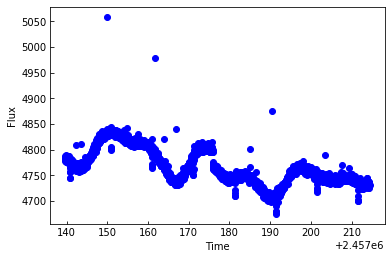

In [80]:
from toolkit import LightCurve

t, f = np.load('data/211916756.npy')

lc = LightCurve(t + 2454833, f)
lc.plot()

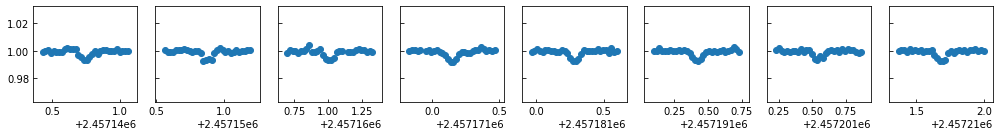

In [81]:
mask_oot = lc.mask_out_of_transit(params, oot_duration_fraction=3)
transits = LightCurve(**mask_oot).get_transit_light_curves(params)

fig, ax = plt.subplots(1, 8, figsize=(14, 2), sharey=True)
times = []
fluxes = []
for i, transit in enumerate(transits): 
    transit.remove_linear_baseline(params, cadence=30*u.min)
    ax[i].scatter(transit.times.jd, transit.fluxes)
    
    times.extend(transit.times.jd)
    fluxes.extend(transit.fluxes)
times = np.array(times)
fluxes = np.array(fluxes)
fig.tight_layout()

In [82]:
phased_times = ((times - params.t0) % params.per)
phased_times[phased_times > params.per/2] -= params.per

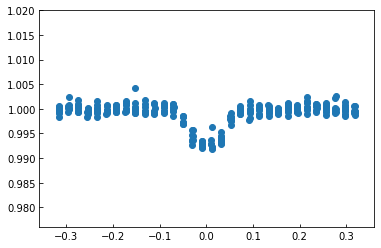

In [83]:
plt.scatter(phased_times, fluxes)

In [93]:
from copy import deepcopy
import emcee

def transit_model(p, times): 
    p0, p1, inc, a = p#, u1, u2 = p
    trial_params = deepcopy(params)
    trial_params.p0 = p0
    trial_params.p1 = p1
    trial_params.inc = inc
    trial_params.a = a
    trial_params.t0 = 0
#     trial_params.u = [u1, u2]
    
    m = TransitModel(trial_params, times, exp_time=0.5/24, supersample_factor=3)
    return m.light_curve(trial_params)

def lnprior(p):
    p0, p1, inc, a = p #, u1, u2 = p
    
    if ((p0 < 0) or (p1 < 0) or (inc > 90) or (p0 > 1) or (p1 > 1) or (a < 1)): # or 
        #(u1 > 1) or (u2 < -1) or (u2 > 1) ): 
        return -np.inf
    return 0

def lnlike(p, times, fluxes, ferr): 
    p0, p1, inc, a = p #, u1, u2 = p

    lp = lnprior(p)
    if np.isfinite(lp): 
        return -0.5 * np.nansum((transit_model(p, times) - fluxes)**2 / ferr**2) 
    return -np.inf

ndim = 4
nwalkers = 2 * ndim

ferr = np.nanstd(fluxes[(phased_times < -params.duration) | (phased_times > params.duration)])

In [95]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(phased_times, fluxes, ferr), 
                               threads=8)

p0 = [1e-5 * np.random.randn(ndim) + 
      np.array([params.p0, params.p1, params.inc, params.a])# , params.u[0], params.u[1]])
      for i in range(nwalkers)]

p1 = sampler.run_mcmc(p0, 5000)[0]
sampler.reset()
sampler.run_mcmc(p1, 10000)
sampler.pool.close()

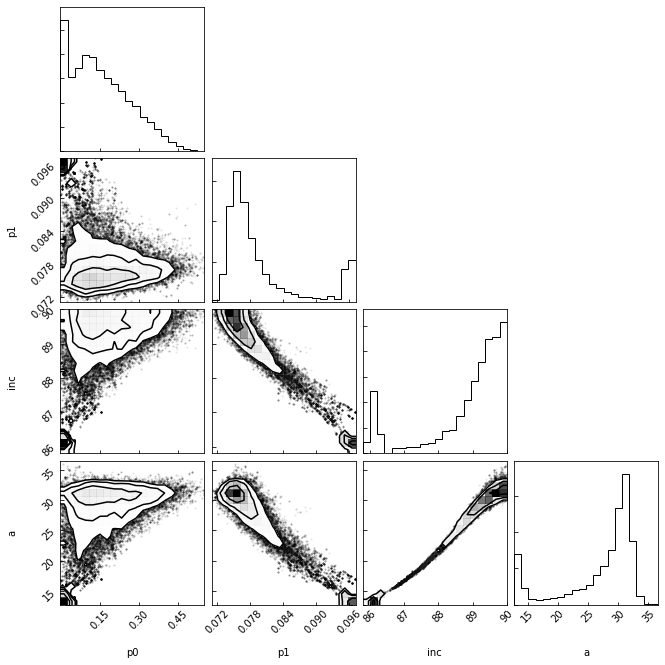

In [96]:
corner(sampler.flatchain, labels='p0, p1, inc, a'.split(', ')); # , u1, u2

(array([  3719.,  28138.,  20419.,   8624.,   4032.,   2266.,   1370.,
           963.,   1137.,   9332.]),
 array([ 0.07104798,  0.0736652 ,  0.07628242,  0.07889963,  0.08151685,
         0.08413407,  0.08675128,  0.0893685 ,  0.09198572,  0.09460293,
         0.09722015]),
 <a list of 1 Patch objects>)

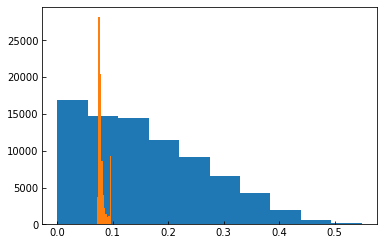

In [97]:
plt.hist(sampler.flatchain[:, 0], histtype='stepfilled')
plt.hist(sampler.flatchain[:, 1], histtype='stepfilled')